<a href="https://colab.research.google.com/github/HaileyTQuach/Medical-Image-Classification-using-CNN/blob/main/Task1_Training_HParam_Tuning_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd
import seaborn as sns
import time
!pip install thop
from thop import profile

# **1. Data Loading and Preprocessing**
## ***Run this block before you go 2. Training and 3. Testing***

For the test run on sample dataset (size of 100) - In the cell where `!gdown` and `!unzip` commands are (right below),


*   ***run only the two lines at the bottom.***
*   gdown and unzip commands on top are to load the entire dataset (size of 6000)


  

In [2]:
# These two lines were used for the task.
# If you want to use the test dataset (size of 100), run only the two lines at the bottom, which is already active.
# !gdown --fuzzy "https://drive.google.com/file/d/1M0uN1jbjbOh3b6fjDfe2qrNnYSJrgfwY/view?usp=drive_link"
# !unzip /content/Dataset_1.zip

!gdown --fuzzy "https://drive.google.com/file/d/1CMR7qOzlY66AFs7xSf4jnpCGqax4CPcA/view?usp=sharing"
!unzip /content/sampled_dataset1.zip

Downloading...
From: https://drive.google.com/uc?id=1CMR7qOzlY66AFs7xSf4jnpCGqax4CPcA
To: /content/sampled_dataset1.zip
100% 13.8M/13.8M [00:00<00:00, 46.8MB/s]
Archive:  /content/sampled_dataset1.zip
   creating: sampled_dataset1/Colorectal Cancer/
   creating: sampled_dataset1/Colorectal Cancer/MUS/
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_0.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_1.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_10.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_11.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_12.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_13.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_14.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_15.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_16.tif  
  inflating: sampled_dataset1/Colorectal Cancer/MUS/sample_17.tif  
  inflating: sample

In [3]:
#This code is for the user who downloaded the original dataset (6000 images)
#dataset_dir = '/content/Colorectal Cancer'

# To test run on sample dataset1, run this line instead, which is already active.
dataset_dir = '/content/sampled_dataset1/Colorectal Cancer'

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
# Load and normalize the dataset
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
# Load and resize the dataset only
org_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform_original)

In [8]:
print("Classes:", full_dataset.classes)
print("Class to index mapping:", full_dataset.class_to_idx)

Classes: ['MUS', 'NORM', 'STR']
Class to index mapping: {'MUS': 0, 'NORM': 1, 'STR': 2}


In [9]:
import torch
# Split dataset indices
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1)  # 10% of 80% = 8% of the wholeimport torch

In [11]:
# Create subsets
train_set = Subset(full_dataset, train_indices)
val_set = Subset(full_dataset, val_indices)
test_set = Subset(full_dataset, test_indices)

In [16]:
batch_size = 32
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
org_loader = torch.utils.data.DataLoader(org_dataset, batch_size=batch_size, shuffle=False)

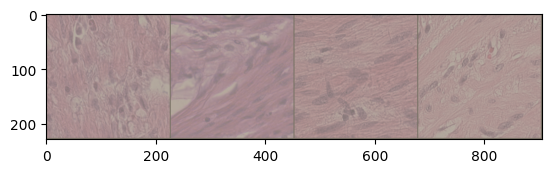

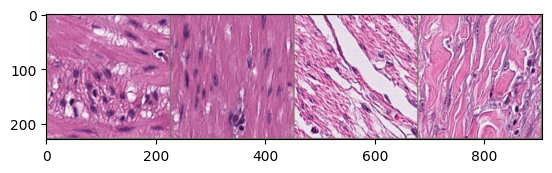

In [17]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Function to show images
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

# Fetch a batch of original images
images_original, _ = next(iter(org_loader))

# Fetch a batch of augmented images
images_augmented, _ = next(iter(train_loader))

# Display original images
imshow(torchvision.utils.make_grid(images_original[:4]))

# Display augmented images
imshow(torchvision.utils.make_grid(images_augmented[:4]))

# **2. Training**
To train and validate a model, run this block.

***Notice:*** The model we used for the next task and the report was saved, with training and testing accuracy reaching 98%. This block of code was rerun to test the timestamp portion, so the output you see here is different.


In [18]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained model without weights
model = models.resnet18(weights=None)

# Get the input dimension of the last layer (or number of neurons in the layer preceeding the output layer)
num_features = model.fc.in_features

# Re-define the final fully connected layer (output layer)
model.fc = nn.Linear(num_features, 3)

In [19]:
# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004083)

In [20]:
# calculate FLOPS
input_data = torch.randn(images_original.size())
flops, params = profile(model, inputs=(input_data, ))
print(flops)
flops_str = "{:.2e}".format(flops)
flops_str = flops_str.replace("e", "×10^").replace("+", "")
print(f"number of FLOPS: {flops_str}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
58352746496.0
number of FLOPS: 5.84×10^10


In [21]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
num_epochs = 21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#check the start time
training_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    epoch_start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #measure and print training time
    train_epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1} training time: {train_epoch_time:.2f}' )

    # Validate the model
    model.eval()
    val_running_loss, val_correct, val_total  = 0, 0, 0
    val_epoch_start_time = time.time()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val_outputs = model(images)
            val_loss = criterion(val_outputs, labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    # calculate validation loss and accuracy
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    #measure and print validation time
    val_epoch_time = time.time() - val_epoch_start_time
    print(f'Epoch {epoch + 1} validation time: {val_epoch_time:.2f}' )

    # Print training and validation metrics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

#print the total time
print("Total --- %s seconds ---" % (time.time() - training_start_time))

Epoch 1 training time: 1.90
Epoch 1 validation time: 0.03
Epoch 1/21, Train Loss: 1.6084, Train Accuracy: 44.44%, Validation Loss: 283150.6875, Validation Accuracy: 62.50%
Epoch 2 training time: 0.35
Epoch 2 validation time: 0.02
Epoch 2/21, Train Loss: 1.1990, Train Accuracy: 56.94%, Validation Loss: 28234.8398, Validation Accuracy: 62.50%
Epoch 3 training time: 0.31
Epoch 3 validation time: 0.02
Epoch 3/21, Train Loss: 1.1241, Train Accuracy: 54.17%, Validation Loss: 25895.5918, Validation Accuracy: 12.50%
Epoch 4 training time: 0.31
Epoch 4 validation time: 0.02
Epoch 4/21, Train Loss: 0.6540, Train Accuracy: 72.22%, Validation Loss: 3275.4126, Validation Accuracy: 25.00%
Epoch 5 training time: 0.32
Epoch 5 validation time: 0.02
Epoch 5/21, Train Loss: 0.8731, Train Accuracy: 73.61%, Validation Loss: 951.3060, Validation Accuracy: 62.50%
Epoch 6 training time: 0.31
Epoch 6 validation time: 0.02
Epoch 6/21, Train Loss: 0.6971, Train Accuracy: 69.44%, Validation Loss: 460.9273, Valida

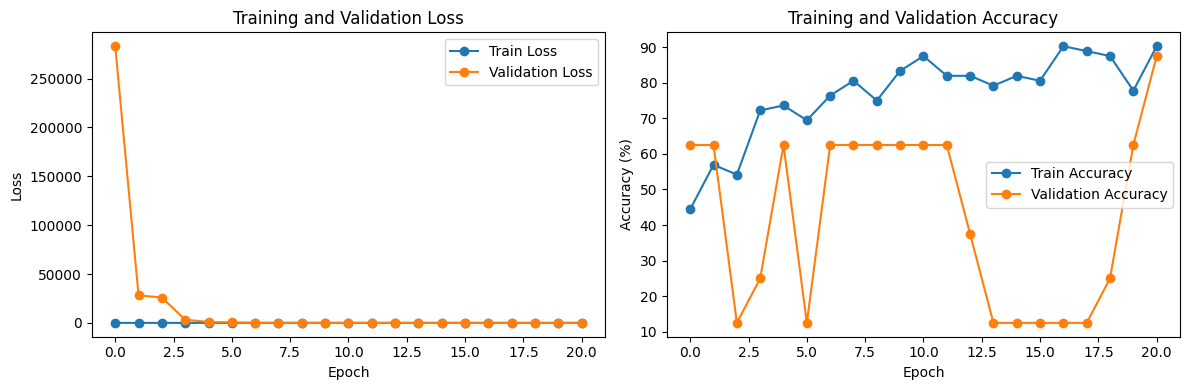

In [22]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

# **3. Hyperparameter Tuning**

In [24]:
!pip install optuna
import optuna

def objective(trial):
    # Suggest a learning rate between 0 and 1
    lr = trial.suggest_float('lr', 0, 1)

    # Suggest discrete uniform distribution for batch size and number of epochs
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30])

    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

     # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training the model
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()
        val_running_loss, val_correct, val_total  = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                val_outputs = model(images)
                val_loss = criterion(val_outputs, labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()

        # calculate validation loss and accuracy
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # Return the best validation accuracy of this trial
    return max(val_accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best hyperparameters:', study.best_params)

[I 2024-01-05 01:48:00,407] A new study created in memory with name: no-name-cf9ff809-3136-4193-b420-f1e81ca35e28
[I 2024-01-05 01:48:10,433] Trial 0 finished with value: 75.0 and parameters: {'lr': 0.1949088651617943, 'batch_size': 16, 'num_epochs': 30}. Best is trial 0 with value: 75.0.
[I 2024-01-05 01:48:17,226] Trial 1 finished with value: 87.5 and parameters: {'lr': 0.8257295522277148, 'batch_size': 16, 'num_epochs': 20}. Best is trial 1 with value: 87.5.
[I 2024-01-05 01:48:23,977] Trial 2 finished with value: 87.5 and parameters: {'lr': 0.15219266613125404, 'batch_size': 64, 'num_epochs': 20}. Best is trial 1 with value: 87.5.
[I 2024-01-05 01:48:34,136] Trial 3 finished with value: 87.5 and parameters: {'lr': 0.775108935101723, 'batch_size': 64, 'num_epochs': 30}. Best is trial 1 with value: 87.5.
[I 2024-01-05 01:48:41,050] Trial 4 finished with value: 75.0 and parameters: {'lr': 0.5002063344676682, 'batch_size': 16, 'num_epochs': 20}. Best is trial 1 with value: 87.5.
[I 202

Best hyperparameters: {'lr': 0.8257295522277148, 'batch_size': 16, 'num_epochs': 20}


***Caution*** Two cells below are there to save the model that has been trained in the cell above.


*   If you wish to save your own model, uncomment them and run the cells.
*   Otherwise, you can simply skip.



In [ ]:
# ONLY RUN THIS IF YOU ARE TRAINING FOR THE FIRS TIME. IF YOU ALREADY HAVE A MODEL,
# DO NOT RUN THIS PART AGAIN.

#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/MyDrive/comp432/')

#torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/COMP432/Project/Project Implementation/final/resnet18_model.pth')

In [ ]:
#torch.save(model.state_dict(), 'resnet18_model.pth')

### Trial logs during the task execution  ❓ 💡 📝

### Try 1
-> train accuracy 64.02% at Epoch 10/10.

number of epoch = 10,

batch size = 64,

optimizer = SGD(with regularization - weight_decay),


### Try 2 - change the optimizer to adam & remove regularization(weight decay) and dropout layer
-> train accuracy 77.92% at Epoch 10/10.

optimizer = adam(without regularization),


### Try 3 - train with more epoch
->  train accuracy 88.98% at Epoch 20/20.

number of epoch = 20


### Try 4 - train the model with the best hyperparameter search with Orion
->  train accuracy 95.56% % at Epoch 19/19.

- best_hyperparmeters :
{ batchsize: 64, epochs: 19, lr: 0.001159 }





### Try 5 - train the model with repreprocessed data
->  train accuracy 95.56% % at Epoch 19/19.

- batch size : 32, learning rate = 0.001, opt = Adam

### Last Try - train the model with repreprocessed data +
hyperparameter search result
->  train accuracy 97.18% at Epoch 21/21
    validation accuracy 97.50% at Epoch 21/21

- batch size : 64, learning rate = 0.004083, epoch 21

-> Save the model as 'resnet18_model.pth'

# **3. Testing**
To test the model you trained above or other trained model you already have, run this block.

***Notice***: To run the tesing code below, you are required to this:

*   Make sure that you already ran the ***1. Data Loading and Preprocessing***
*   If you are going to load and use the pre-trained model's weight, do not make any directory.
*   The `!gdown` code to load the pre-trained model is already there. Simply run the cell to download it.
*   If you are using the model you trained above, ignore this and keep going.

In [ ]:
#Ignore this cell

# ADD SHORTCUT FROM COMP432 FOLDER TO YOUR COLAB NOTEBOOK FOLDER THEN ON THE LEFT HAND SIZE IN COLAB, UNDER "FILE", LOOK FOR THE PATH.
# LOAD THE MODEL

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


###This block is for the user who is going to use a pre-trained model (***resnet18_model_98.pth***) and use its weight. If you have run the training loop and want to use the model above, you can skip this block.

In [ ]:
model = resnet18(weights = None)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004083)

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1UmEHRAYuAhiqxZzi-oLxtstSE0YptOzf/view?usp=drive_link'

In [ ]:
#resnet18_model_98 is the best trained model.

state_dict = torch.load ('/content/resnet18_model_98.pth')
#in case you are curious what the weights look like ...
#print(state_dict)

In [ ]:
#match the pretrained weight in the initialized model
model.load_state_dict(state_dict)

<All keys matched successfully>

Start of the testing loop is here!

***Notice***: Two lines of code where we call `torch.stack()` need attention.


*   The lines that were used for the original dataset (6000) are commented.
*   ***The lines for the test run (dataset size 100) are already active.***


In [ ]:
# testing with the test dataset
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
running_loss = 0
total = 0
correct = 0

#to append the result
y_pred = []
y_test = []

#testing loop
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted)
    y_test.append(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#for scikit learn classification report
#These two lines below were used for the experiment.
#If you are running with the dataset with (6000), use these instead of top two lines of code of torch.stack
# y_pred_torch = torch.stack(y_pred[0:-1], dim=1)
# y_test_torch = torch.stack(y_test[0:-1], dim=1)

y_pred_torch = torch.stack(y_pred[:], dim=1)
y_test_torch = torch.stack(y_test[:], dim=1)
y_pred_torch = y_pred_torch.cpu().detach().numpy()
y_test_torch = y_test_torch.cpu().detach().numpy()
y_pred_torch = np.reshape(y_pred_torch,(-1, 1))
y_test_torch = np.reshape(y_test_torch, (-1, 1))

target_names = ['MUS', 'NORM', 'STR']

#print metrics
print(classification_report(y_test_torch, y_pred_torch, target_names = target_names))
test_loss = running_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

              precision    recall  f1-score   support

         MUS       0.98      0.89      0.93       399
        NORM       0.99      0.92      0.95       386
         STR       0.84      0.99      0.91       367

    accuracy                           0.93      1152
   macro avg       0.94      0.93      0.93      1152
weighted avg       0.94      0.93      0.93      1152

Test Loss: 0.1920, Test Accuracy: 93.00%


#**4. Feature extracion and t-SNE visualization**

In [ ]:
#to append feature extraction and target
extracted_features = []
y_tsne = []

#remove last classification layer from our model
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

#loop
with torch.no_grad():
  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    features = newmodel(images)
    features = features.view(features.size(0), -1)
    extracted_features.append(features.cpu().numpy())
    y_tsne.append(labels)

# Concatenate all features to get the full feature set
extracted_features = np.concatenate(extracted_features, axis=0)
y_tsne = np.concatenate(y_tsne, axis=0)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
tsne_result = tsne.fit_transform(extracted_features)

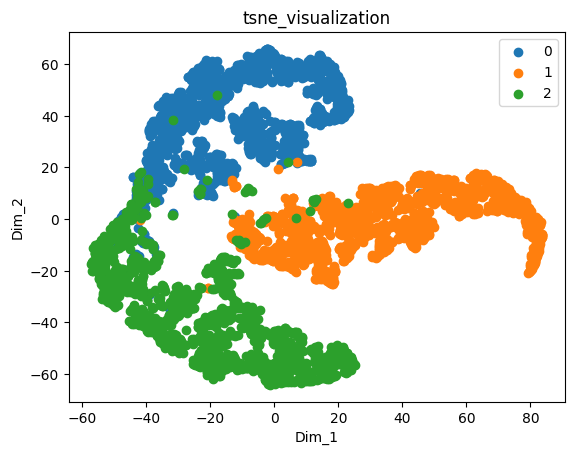

In [ ]:
classes = list(set(y_tsne))
plt.figure()
for cl in classes:
  indices = np.where(y_tsne==cl)[0]
  plt.title('tsne_visualization')
  plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label = cl)
  plt.ylabel('Dim_2')
  plt.xlabel('Dim_1')
  plt.legend()